##### L'utilisation de la PredictionErrorDisplay nécessite au moins une version 1.2.1 de scikit-learn

In [153]:
#!pip install -U --user scikit-learn 
#!pip install lightgbm
#!pip install catboost
#!pip install shap
#!pip install treeplot

  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2959 sha256=b18154f8f22c567a9ace472c8d3b506200fae2dc8e0e162abf5d7c102bd2e2ba
  Stored in directory: c:\users\yassi\appdata\local\pip\cache\wheels\f8\e0\3d\9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=e580985e156cd1e56323ab9c13420c0dfd702eccc55de3973a92a6f7ed1a3237
  Stored in directory: c:\users\yassi\appdata\local\pip\cache\wheels\04\5f\3e\46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built sklearn wget


In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
import warnings

import pingouin as pg
import scipy as sp
import shap
import graphviz
from scipy.stats import kstest
from lightgbm import LGBMRegressor,plot_importance,plot_metric,plot_tree
from catboost import CatBoostRegressor,Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (r2_score,mean_squared_error,mean_absolute_error,
                             mean_absolute_percentage_error,max_error,
                             median_absolute_error,PredictionErrorDisplay)
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn import set_config

set_config(display='diagram',print_changed_only=False)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth',None)

## Importing Data

### Loading 

In [4]:
?pd.read_csv

Signature:
pd.read_csv(
    filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]',
    sep=<no_default>,
    delimiter=None,
    header='infer',
    names=<no_default>,
    index_col=None,
    usecols=None,
    squeeze=None,
    prefix=<no_default>,
    mangle_dupe_cols=True,
    dtype: 'DtypeArg | None' = None,
    engine: 'CSVEngine | None' = None,
    converters=None,
    true_values=None,
    false_values=None,
    skipinitialspace=False,
    skiprows=None,
    skipfooter=0,
    nrows=None,
    na_values=None,
    keep_default_na=True,
    na_filter=True,
    verbose=False,
    skip_blank_lines=True,
    parse_dates=None,
    infer_datetime_format=False,
    keep_date_col=False,
    date_parser=None,
    dayfirst=False,
    cache_dates=True,
    iterator=False,
    chunksize=None,
    compression: 'CompressionOptions' = 'infer',
    thousands=None,
    decimal: 'str' = '.',
    lineterminator=None,
    quotechar='"',
    quoting=0,
    doublequote=True,
    esc

In [2]:
df=pd.read_csv("./data/train.csv",index_col="Id",dtype={'MSSubClass':'category',
                    'OverallQual': 'category','OverallCond':'category','YearBuilt':'category',
                    'YearRemodAdd':'category','YrSold':'category','MoSold':'category','GarageYrBlt':'category'})

In [3]:
df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                   
1          60       RL         65.0     8450   Pave   NaN      Reg   
2          20       RL         80.0     9600   Pave   NaN      Reg   
3          60       RL         68.0    11250   Pave   NaN      IR1   
4          70       RL         60.0     9550   Pave   NaN      IR1   
5          60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

   Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt  \
Id                                                                    
1        Norm     1Fam     2Story           7           5      2003   
2        Norm     1Fam     1Story           6           8      1976   
3        Norm     1Fam     2Story           7           5      2001   
4        Norm     1Fam     2Story           7           5      1915   
5        Norm     1Fam     2Story           8           5      2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                      
1          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2          1976     Gable  CompShg     MetalSd     MetalSd       None   
3          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
5          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                             
1        196.0        Gd        TA      PConc       Gd       TA           No   
2          0.0        TA        TA     CBlock       Gd       TA           Gd   
3        162.0        Gd        TA      PConc       Gd       TA           Mn   
4          0.0        TA        TA     BrkTil       TA       Gd           No   
5        350.0        Gd        TA      PConc       Gd       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                             
1           GLQ         706          Unf           0        150          856   
2           ALQ         978          Unf           0        284         1262   
3           GLQ         486          Unf           0        434          920   
4           ALQ         216          Unf           0        540          756   
5           GLQ         655          Unf           0        490         1145   

   Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                             
1     GasA        Ex          Y      SBrkr       856       854             0   
2     GasA        Ex          Y      SBrkr      1262         0             0   
3     GasA        Ex          Y      SBrkr       920       866             0   
4     GasA        Gd          Y      SBrkr       961       756             0   
5     GasA        Ex          Y      SBrkr      1145      1053             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                            
1        1710             1             0         2         1             3   
2        1262             0             1         2         0             3  

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   object  
 2   LotFrontage    1201 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   object  
 5   Alley          91 non-null     object  
 6   LotShape       1460 non-null   object  
 7   LandContour    1460 non-null   object  
 8   Utilities      1460 non-null   object  
 9   LotConfig      1460 non-null   object  
 10  LandSlope      1460 non-null   object  
 11  Neighborhood   1460 non-null   object  
 12  Condition1     1460 non-null   object  
 13  Condition2     1460 non-null   object  
 14  BldgType       1460 non-null   object  
 15  HouseStyle     1460 non-null   object  
 16  OverallQual    1460 non-null   category
 17  OverallCond    1460 non-null   ca

In [5]:
df.select_dtypes(include="object").columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [6]:
df[df.select_dtypes(include="object").columns]=df[df.select_dtypes(include="object").columns].astype('category')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   category
 2   LotFrontage    1201 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   category
 5   Alley          91 non-null     category
 6   LotShape       1460 non-null   category
 7   LandContour    1460 non-null   category
 8   Utilities      1460 non-null   category
 9   LotConfig      1460 non-null   category
 10  LandSlope      1460 non-null   category
 11  Neighborhood   1460 non-null   category
 12  Condition1     1460 non-null   category
 13  Condition2     1460 non-null   category
 14  BldgType       1460 non-null   category
 15  HouseStyle     1460 non-null   category
 16  OverallQual    1460 non-null   category
 17  OverallCond    1460 non-null   ca

In [8]:
df.describe()

LotFrontage        LotArea   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1201.000000    1460.000000  1452.000000  1460.000000  1460.000000   
mean     70.049958   10516.828082   103.685262   443.639726    46.549315   
std      24.284752    9981.264932   181.066207   456.098091   161.319273   
min      21.000000    1300.000000     0.000000     0.000000     0.000000   
25%      59.000000    7553.500000     0.000000     0.000000     0.000000   
50%      69.000000    9478.500000     0.000000   383.500000     0.000000   
75%      80.000000   11601.500000   166.000000   712.250000     0.000000   
max     313.000000  215245.000000  1600.000000  5644.000000  1474.000000   

         BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000   1460.000000   
mean    567.240411  1057.429452  1162.626712   346.992466      5.844521   
std     441.866955   438.705324   386.587738   436.528436     48.623081   
min       0.000000     0.000000   334.000000     0.000000      0.000000   
25%     223.000000   795.750000   882.000000     0.000000      0.000000   
50%     477.500000   991.500000  1087.000000     0.000000      0.000000   
75%     808.000000  1298.250000  1391.250000   728.000000      0.000000   
max    2336.000000  6110.000000  4692.000000  2065.000000    572.000000   

         GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  \
count  1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
mean   1515.463699      0.425342      0.057534     1.565068     0.382877   
std     525.480383      0.518911      0.238753     0.550916     0.502885   
min     334.000000      0.000000      0.000000     0.000000     0.000000   
25%    1129.500000      0.000000      0.000000     1.000000     0.000000   
50%    1464.000000      0.000000      0.000000     2.000000     0.000000   
75%    1776.750000      1.000000      0.000000     2.000000     1.000000   
max    5642.000000      3.000000      2.000000     3.000000     2.000000   

       BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces   GarageCars  \
count   1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
mean       2.866438      1.046575      6.517808     0.613014     1.767123   
std        0.815778      0.220338      1.625393     0.644666     0.747315   
min        0.000000      0.000000      2.000000     0.000000     0.000000   
25%        2.000000      1.000000      5.000000     0.000000     1.000000   
50%        3.000000      1.000000      6.000000     1.000000     2.000000   
75%        3.000000      1.000000      7.000000     1.000000     2.000000   
max        8.000000      3.000000     14.000000     3.000000     4.000000   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    472.980137    94.244521    46.660274      21.954110     3.409589   
std     213.804841   125.338794    66.256028      61.119149    29.317331   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     334.500000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    25.000000       0.000000     0.000000   
75%     576.000000   168.000000    68.000000       0.000000     0.000000   
max    1418.000000   857.000000   547.000000     552.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal      SalePrice  
count  1460.000000  1460.000000   1460.000000    1460.000000  
mean     15.060959     2.758904     43.489041  180921.195890  
std      55.757415    40.177307    496.123024   79442.502883  
min       0.000000     0.000000      0.000000   34900.000000  
25%       0.000000     0.000000      0.000000  129975.000000  
50%       0.000000     0.000000      0.000000  163000.000000  
75%       0.000000     0.000000      0.000000  214000.000000  
max     480.000000   738.000000  15500.000000  755000.000000

In [9]:
df.describe(include="category")

MSSubClass MSZoning Street Alley LotShape LandContour Utilities  \
count        1460     1460   1460    91     1460        1460      1460   
unique         15        5      2     2        4           4         2   
top            20       RL   Pave  Grvl      Reg         Lvl    AllPub   
freq          536     1151   1454    50      925        1311      1459   

       LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
count       1460      1460         1460       1460       1460     1460   
unique         5         3           25          9          8        5   
top       Inside       Gtl        NAmes       Norm       Norm     1Fam   
freq        1052      1382          225       1260       1445     1220   

       HouseStyle OverallQual OverallCond YearBuilt YearRemodAdd RoofStyle  \
count        1460        1460        1460      1460         1460      1460   
unique          8          10           9       112           61         6   
top        1Story           5           5      2006         1950     Gable   
freq          726         397         821        67          178      1141   

       RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond  \
count      1460        1460        1460       1452      1460      1460   
unique        8          15          16          4         4         5   
top     CompShg     VinylSd     VinylSd       None        TA        TA   
freq       1434         515         504        864       906      1282   

       Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  \
count        1460     1423     1423         1422         1423         1422   
unique          6        4        4            4            6            6   
top         PConc       TA       TA           No          Unf          Unf   
freq          647      649     1311          953          430         1256   

       Heating HeatingQC CentralAir Electrical KitchenQual Functional  \
count     1460      1460       1460       1459        1460       1460   
unique       6         5          2          5           4          7   
top       GasA        Ex          Y      SBrkr          TA        Typ   
freq      1428       741       1365       1334         735       1360   

       FireplaceQu GarageType GarageYrBlt GarageFinish GarageQual GarageCond  \
count          770       1379        1379         1379       1379       1379   
unique           5          6          97            3          5          5   
top             Gd     Attchd        2005          Unf         TA         TA   
freq           380        870          65          605       1311       1326   

       PavedDrive PoolQC  Fence MiscFeature MoSold YrSold SaleType  \
count        1460      7    281          54   1460   1460     1460   
unique          3      3      4           4     12      5        9   
top             Y     Gd  MnPrv        Shed      6   2009       WD   
freq         1340      3    157          49    253    338     1267   

       SaleCondition  
count           1460  
unique             6  
top           Normal  
freq            1198

In [10]:
df.duplicated().sum()

0

### Categorical variables

<AxesSubplot:>

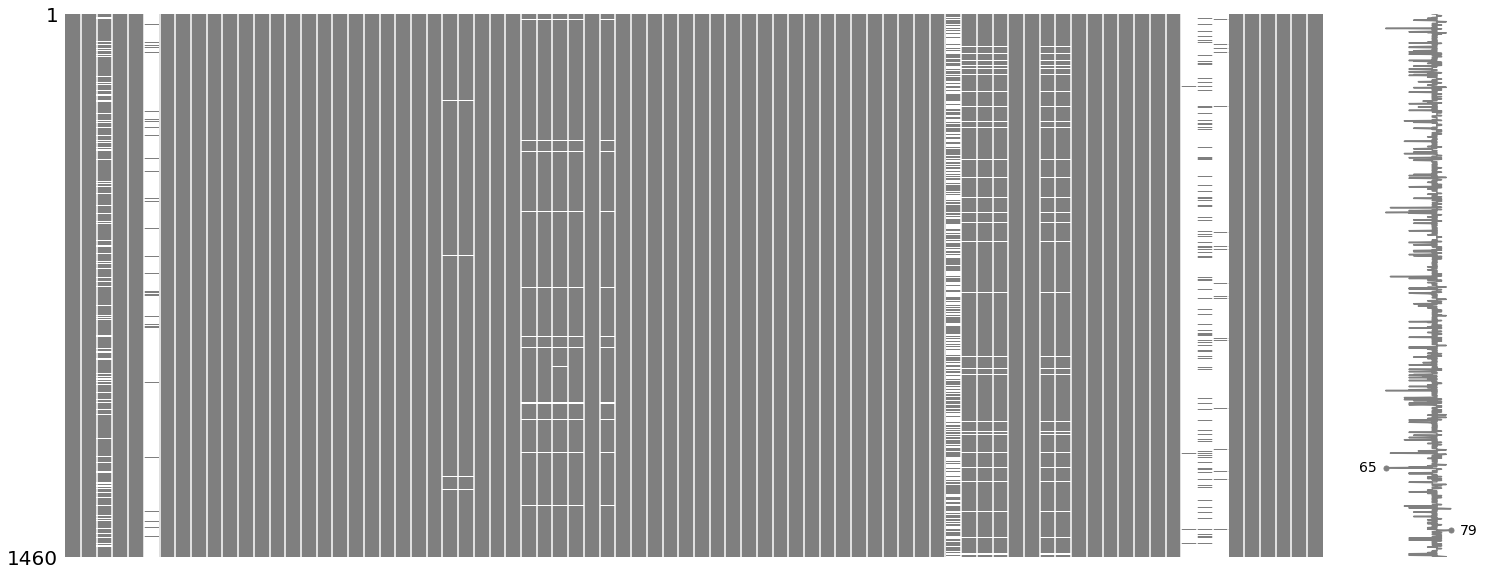

In [11]:
msno.matrix(df,color=(0.5,0.5,0.5))

In [12]:
df.isna().sum()[df.isna().any()]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [13]:
warnings.filterwarnings('ignore') # Turn off warnings
labels={'Alley':'No alley access',
        'BsmtQual':'No Basement',
        'BsmtCond':'No Basement',
        'BsmtExposure':'No Basement',
        'BsmtFinType1':'No Basement',
        'BsmtFinType2':'No Basement',
        'FireplaceQu':'No Fireplace',
        'GarageType':'No Garage',
        'GarageFinish':'No Garage',
        'GarageQual':'No Garage',
        'GarageCond':'No Garage','PoolQC':'No Pool',
        'Fence':'No Fence',
        'MiscFeature':'None',
        'GarageYrBlt':'No Garage'}

for variable,label in labels.items():
    # Set a new category to the variable
    df[variable].cat.add_categories(label,inplace=True)
    
    #Replace all the NA's by the new category
    df[variable].where(df[variable].notna(),other=label,inplace=True)

<AxesSubplot:>

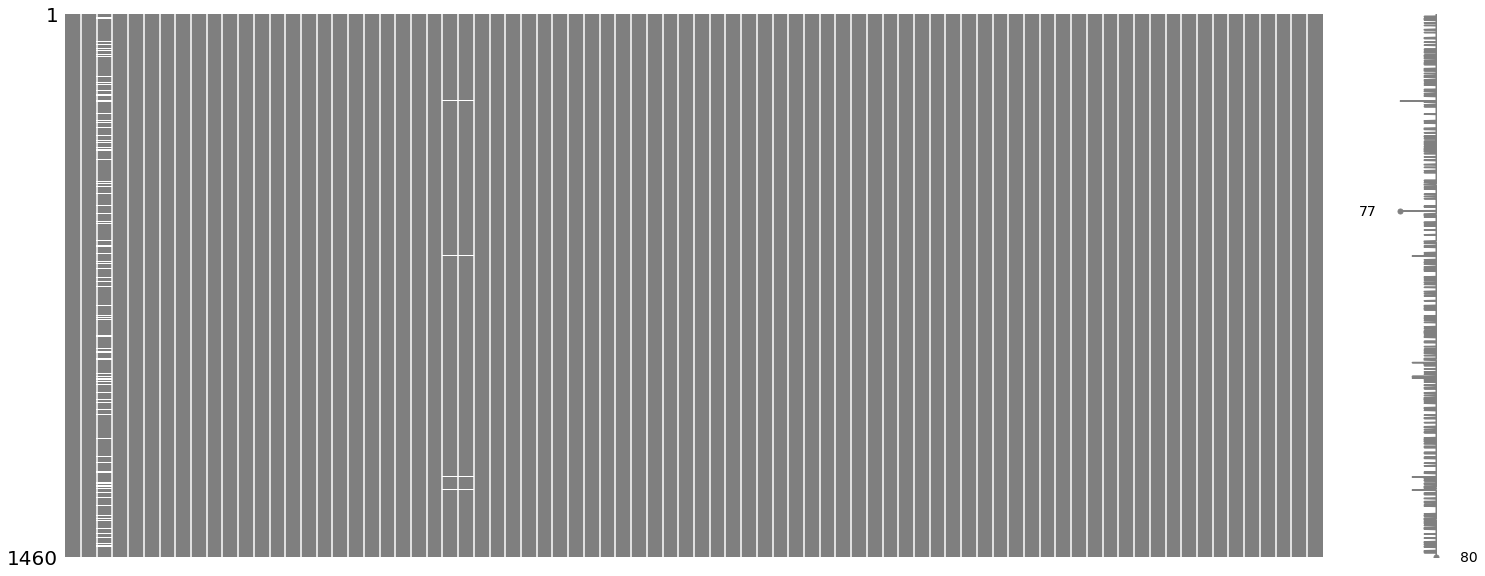

In [14]:
msno.matrix(df,color=(0.5,0.5,0.5))

In [15]:
df.isna().sum()[df.isna().any()]

LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
dtype: int64

In [16]:
labels={'LandContour':['Lvl','Bnk','HLS','Low'],
        'Utilities':['ELO','NoSeWa','NoSeWr','AllPub'],
        'LandSlope':['Gtl','Mod','Sev'],
        'LotShape':['Reg','IR1','IR2','IR3'],
        'HouseStyle':['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl'],
        'OverallQual':['1','2','3','4','5','6','7','8','9','10'],'OverallCond':['1','2','3','4','5','6','7','8','9','10'],
        'ExterQual':['Po','Fa','TA','Gd','Ex'],
        'ExterCond':['Po','Fa','TA','Gd','Ex'],
        'BsmtQual':['No Basement','Po','Fa','TA','Gd','Ex'],
        'BsmtCond':['No Basement','Po','Fa','TA','Gd','Ex'],
        'BsmtExposure':['No Basement','No','Mn','Av','Gd'],
        'BsmtFinType1':['No Basement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
        'BsmtFinType2':['No Basement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
        'HeatingQC':['Po','Fa','TA','Gd','Ex'],
        'KitchenQual':['Po','Fa','TA','Gd','Ex'],
        'Functional':['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],
        'FireplaceQu':['No Fireplace','Po','Fa','TA','Gd','Ex'],
        'GarageQual':['No Garage','Po','Fa','TA','Gd','Ex'],
        'GarageFinish':['No Garage','Unf','RFn','Fin'],
        'GarageCond':['No Garage','Po','Fa','TA','Gd','Ex'],
        'PavedDrive':['N','P','Y'],
        'PoolQC':['No Pool','Po','Fa','TA','Gd','Ex'],
        'Fence':['No Fence','MnWw','GdWo','MnPrv','GdPrv']
       }

for var_name,label in labels.items():
    for value in label:
        if value not in df[var_name].cat.categories:
            df[var_name].cat.add_categories(value,inplace=True)
        
    df[var_name].cat.reorder_categories(label,inplace=True)
    df[var_name].cat.as_ordered(inplace=True)

In [17]:
df.describe(include='category')

MSSubClass MSZoning Street            Alley LotShape LandContour  \
count        1460     1460   1460             1460     1460        1460   
unique         15        5      2                3        4           4   
top            20       RL   Pave  No alley access      Reg         Lvl   
freq          536     1151   1454             1369      925        1311   

       Utilities LotConfig LandSlope Neighborhood Condition1 Condition2  \
count       1460      1460      1460         1460       1460       1460   
unique         2         5         3           25          9          8   
top       AllPub    Inside       Gtl        NAmes       Norm       Norm   
freq        1459      1052      1382          225       1260       1445   

       BldgType HouseStyle OverallQual OverallCond YearBuilt YearRemodAdd  \
count      1460       1460        1460        1460      1460         1460   
unique        5          8          10           9       112           61   
top        1Fam     1Story           5           5      2006         1950   
freq       1220        726         397         821        67          178   

       RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual  \
count       1460     1460        1460        1460       1452      1460   
unique         6        8          15          16          4         4   
top        Gable  CompShg     VinylSd     VinylSd       None        TA   
freq        1141     1434         515         504        864       906   

       ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
count       1460       1460     1460     1460         1460         1460   
unique         5          6        5        5            5            7   
top           TA      PConc       TA       TA           No          Unf   
freq        1282        647      649     1311          953          430   

       BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual  \
count          1460    1460      1460       1460       1459        1460   
unique            7       6         5          2          5           4   
top             Unf    GasA        Ex          Y      SBrkr          TA   
freq           1256    1428       741       1365       1334         735   

       Functional   FireplaceQu GarageType GarageYrBlt GarageFinish  \
count        1460          1460       1460        1460         1460   
unique          7             6          7          98            4   
top           Typ  No Fireplace     Attchd   No Garage          Unf   
freq         1360           690        870          81          605   

       GarageQual GarageCond PavedDrive   PoolQC     Fence MiscFeature MoSold  \
count        1460       1460       1460     1460      1460        1460   1460   
unique          6          6          3        4         5           5     12   
top            TA         TA          Y  No Pool  No Fence        None      6   
freq         1311       1326       1340     1453      1179        1406    253   

       YrSold SaleType SaleCondition  
count    1460     1460          1460  
unique      5        9             6  
top      2009       WD        Normal  
freq      338     1267          1198

In [18]:
df[['MasVnrType','MasVnrArea']].groupby('MasVnrType').describe()

MasVnrArea                                                      \
                count        mean         std   min    25%    50%     75%   
MasVnrType                                                                  
BrkCmn           15.0  247.666667  182.423239  41.0   91.5  192.0  381.50   
BrkFace         445.0  259.008989  215.137888   0.0  114.0  202.0  336.00   
None            864.0    1.094907   18.569659   0.0    0.0    0.0    0.00   
Stone           128.0  239.304688  172.129257   0.0  111.5  206.5  296.25   

                    
               max  
MasVnrType          
BrkCmn       621.0  
BrkFace     1600.0  
None         344.0  
Stone        860.0

In [19]:
df[['BsmtFinType1','BsmtFinSF1']].groupby('BsmtFinType1',dropna=False).describe()

BsmtFinSF1                                                \
                  count        mean         std    min     25%    50%   
BsmtFinType1                                                            
No Basement        37.0    0.000000    0.000000    0.0    0.00    0.0   
Unf               430.0    0.000000    0.000000    0.0    0.00    0.0   
LwQ                74.0  379.540541  269.696236   16.0  187.00  318.0   
Rec               133.0  516.601504  272.460866  129.0  312.00  456.0   
BLQ               148.0  536.668919  270.945193   25.0  349.50  516.5   
ALQ               220.0  619.863636  320.433310   20.0  383.25  593.5   
GLQ               418.0  801.729665  490.888087    2.0  517.00  739.5   

                               
                  75%     max  
BsmtFinType1                   
No Basement      0.00     0.0  
Unf              0.00     0.0  
LwQ            503.00  1237.0  
Rec            637.00  1332.0  
BLQ            675.00  1277.0  
ALQ            788.25  1880.0  
GLQ           1081.25  5644.0

In [20]:
df[['BsmtFinType2','BsmtFinSF2']].groupby('BsmtFinType2',dropna=False).describe()

BsmtFinSF2                                                      \
                  count        mean         std   min    25%    50%     75%   
BsmtFinType2                                                                  
No Basement        38.0   12.605263   77.704061   0.0    0.0    0.0    0.00   
Unf              1256.0    0.000000    0.000000   0.0    0.0    0.0    0.00   
LwQ                46.0  310.739130  200.198394  35.0  169.5  277.5  437.25   
Rec                54.0  392.462963  274.344276  64.0  180.0  320.0  498.75   
BLQ                33.0  329.909091  240.181229  28.0  147.0  294.0  441.00   
ALQ                19.0  626.157895  328.279736  64.0  539.0  606.0  702.00   
GLQ                14.0  658.000000  335.447806  41.0  507.0  623.0  939.25   

                      
                 max  
BsmtFinType2          
No Basement    479.0  
Unf              0.0  
LwQ           1061.0  
Rec           1085.0  
BLQ           1120.0  
ALQ           1474.0  
GLQ           1127.0

In [21]:
(df[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF']].sum(axis=1)==df['TotalBsmtSF']).value_counts()

True    1460
dtype: int64

## EDA: Exploratory Data Analysis

### Summary

In [22]:
df['SalePrice'].describe().astype(int)

count      1460
mean     180921
std       79442
min       34900
25%      129975
50%      163000
75%      214000
max      755000
Name: SalePrice, dtype: int32

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

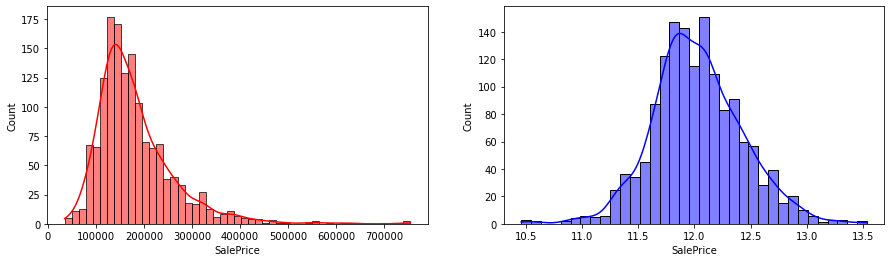

In [23]:
fig, axes=plt.subplots(nrows=1, ncols=2,figsize=(15,4))
sns.histplot(df,x='SalePrice',color='red',kde=True,ax=axes[0])

sns.histplot(np.log(df['SalePrice']),color='blue',kde=True,ax=axes[1])

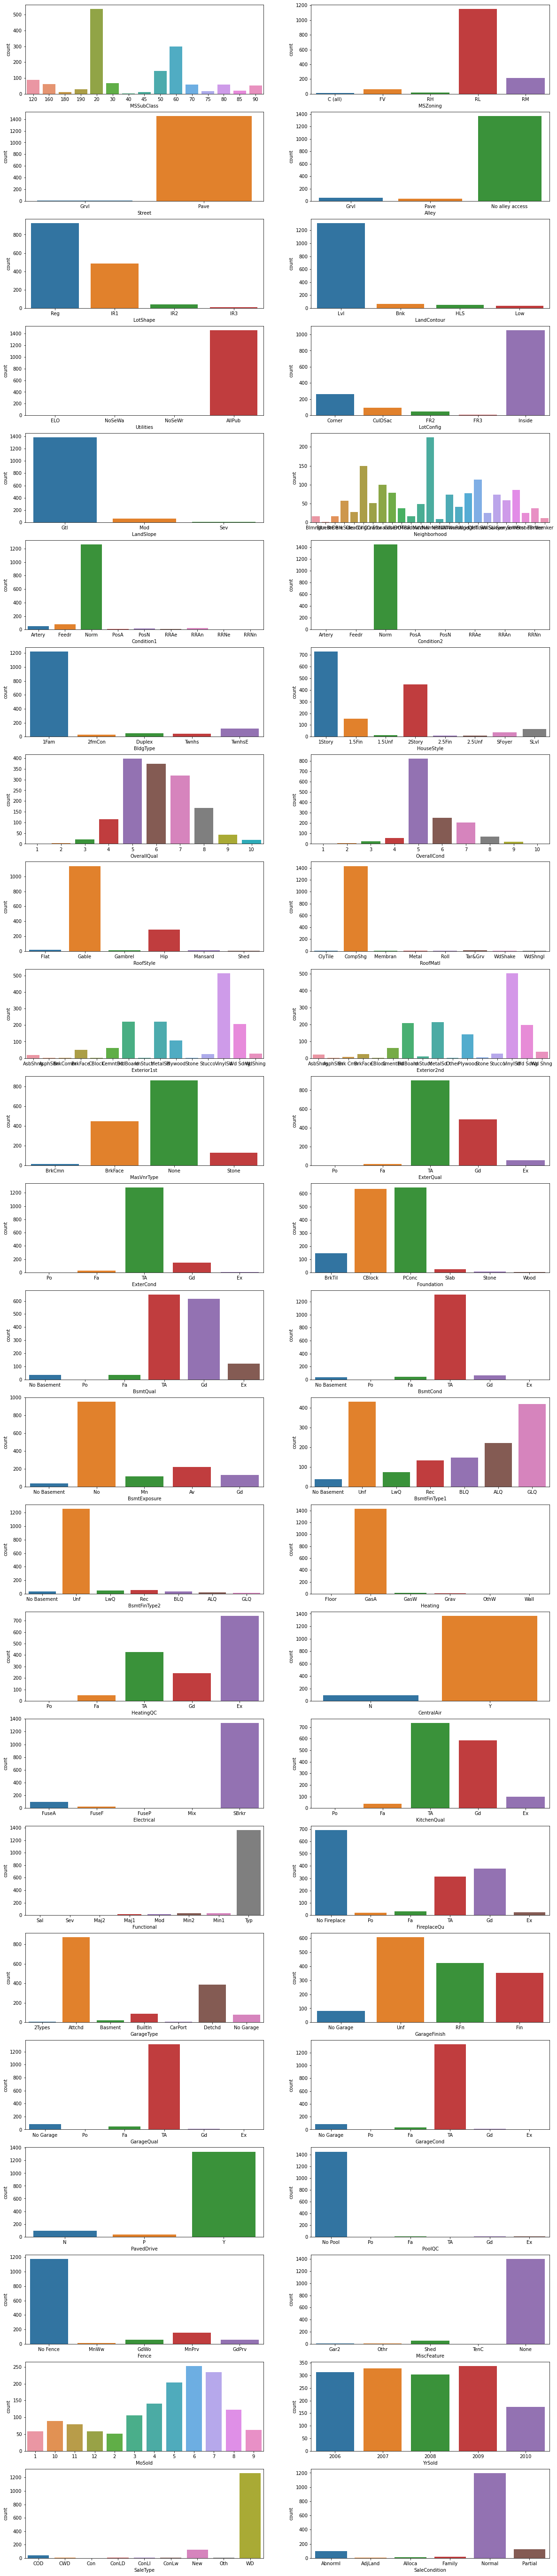

In [24]:
ncols=2
categorial_features=df.select_dtypes('category').columns
categorial_features=categorial_features.delete(categorial_features.get_indexer(['YearBuilt','YearRemodAdd','GarageYrBlt']))
nrows=len(categorial_features)//ncols

fig,axes=plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,100))
axes=axes.ravel()

for i, col_name in enumerate(categorial_features):
        ax=axes[i]
        sns.countplot(data=df,x=col_name,ax=ax)

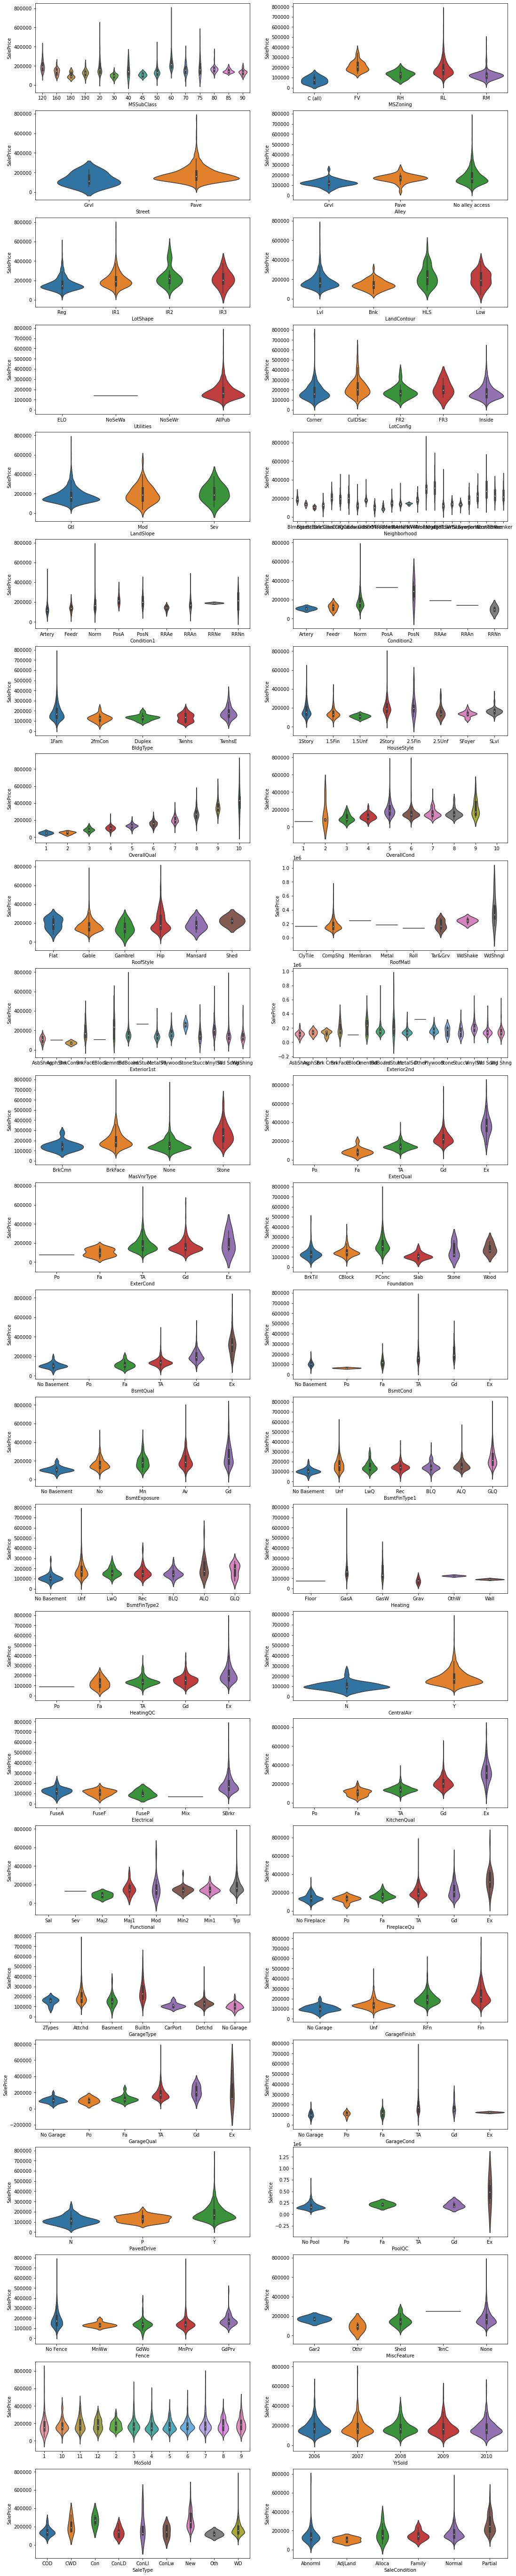

In [25]:
fig, axes=plt.subplots(nrows=nrows,ncols=ncols,figsize=(18,100))
axes=axes.ravel()

for i, col_name in enumerate(categorial_features):
    ax=axes[i]
    sns.violinplot(x=col_name,y='SalePrice',data=df,ax=ax)

### Analysis of variance

In [26]:
tuple(categorial_features)

('MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition')

In [27]:
def normal_color(row):
    return [
        "background-color:#7FFFD4;font-weight:bold" 
        if cell==True
        else ""
        for cell in row
    ]

In [28]:
# Normality test
tab=pd.DataFrame()
for col_name in list(categorial_features):
    tab_norm=pg.normality(data=df,dv='SalePrice',group=col_name,method='shapiro')
    tab_norm=pd.concat([tab_norm,pg.normality(data=df,dv='SalePrice',group=col_name,method='jarque_bera')],ignore_index=False,axis=1)
    tab=pd.concat([tab,tab_norm])
tab

W          pval normal             W          pval  \
60               0.775850  6.139068e-20  False   1471.722784  0.000000e+00   
20               0.866903  5.920462e-21  False    496.395164  0.000000e+00   
70               0.944949  9.074402e-03  False     11.235850  3.632170e-03   
50               0.813904  3.043471e-12  False    332.180685  0.000000e+00   
190              0.967450  4.719664e-01   True      2.646665  2.662465e-01   
45               0.962383  8.172343e-01   True      0.563683  7.543933e-01   
90               0.953822  4.236469e-02  False      2.381090  3.040556e-01   
120              0.931469  1.849556e-04  False     16.813826  2.233182e-04   
30               0.987522  7.253652e-01   True      0.138224  9.332223e-01   
85               0.890807  2.782728e-02  False      3.725044  1.552806e-01   
80               0.779264  6.215419e-08  False    188.924602  0.000000e+00   
160              0.964524  6.627904e-02   True      0.333387  8.464588e-01   
75               0.823703  5.722929e-03  False      8.817536  1.217017e-02   
180              0.753312  3.916027e-03  False      1.681685  4.313469e-01   
40               0.940139  6.551747e-01   True      0.379990  8.269631e-01   
RL               0.860955  1.031048e-30  False   2904.125144  0.000000e+00   
RM               0.737986  2.691940e-18  False   3007.453802  0.000000e+00   
C (all)          0.939007  5.420225e-01   True      0.605208  7.388916e-01   
FV               0.920028  4.477961e-04  False     10.665407  4.830992e-03   
RH               0.962967  7.158138e-01   True      0.295249  8.627550e-01   
Pave             0.868947  3.107201e-33  False   3437.086985  0.000000e+00   
Grvl             0.936607  6.320003e-01   True      0.553280  7.583273e-01   
No alley access  0.871144  3.715155e-32  False   3019.450116  0.000000e+00   
Grvl             0.937854  1.109044e-02  False     25.171660  3.420136e-06   
Pave             0.942345  3.785087e-02  False     12.509120  1.921672e-03   
Reg              0.871639  6.945240e-27  False   1193.337412  0.000000e+00   
IR1              0.855345  1.074925e-20  False   1794.623683  0.000000e+00   
IR2              0.824097  1.837073e-05  False     17.483083  1.598074e-04   
IR3              0.968439  8.760109e-01   True      0.094327  9.539315e-01   
Lvl              0.859944  1.275925e-32  False   3856.532080  0.000000e+00   
Bnk              0.967441  9.364726e-02   True      7.513511  2.335941e-02   
HLS              0.938477  1.173317e-02  False      5.627705  5.997350e-02   
Low              0.979180  7.177106e-01   True      0.493317  7.814074e-01   
NoSeWa                NaN           NaN  False           NaN           NaN   
AllPub           0.869816  3.391829e-33  False   3431.181548  0.000000e+00   
Inside           0.887472  5.577334e-27  False   1081.271565  0.000000e+00   
FR2              0.898954  6.670356e-04  False     24.790296  4.138621e-06   
Corner           0.798771  9.962283e-18  False   2604.603981  0.000000e+00   
CulDSac          0.836732  8.653961e-09  False    123.357628  0.000000e+00   
FR3              0.950595  7.198346e-01   True      0.354641  8.375113e-01   
Gtl              0.862255  3.706794e-33  False   3736.970155  0.000000e+00   
Mod              0.946052  6.774888e-03  False     16.523782  2.581703e-04   
Sev              0.986665  9.977295e-01   True      0.327623  8.489019e-01   
CollgCr          0.940985  6.271883e-06  False     53.269673  2.707945e-12   
Veenker          0.909294  2.392407e-01   True      1.153185  5.618096e-01   
Crawfor          0.949379  2.969441e-02  False      5.072023  7.918157e-02   
NoRidge          0.719147  1.583704e-07  False     77.772165  0.000000e+00   
Mitchel          0.940968  1.613032e-02  False     10.137597  6.289973e-03   
Somerst          0.945260  1.170828e-03  False     12.806246  1.656377e-03   
NWAmes           0.955083  1.097800e-02  False      7.049588  2.945788e-02   
OldTown          0.693512  4.878671e-14  False

In [32]:
pg.homoscedasticity(data=df,dv='SalePrice',group=categorial_features)

TypeError: unhashable type: 'Index'

In [26]:
tab=pd.DataFrame()
for col_name in list(categorial_features):
    tab=pd.concat([tab,pg.anova(data=df,dv='SalePrice',between=col_name)],ignore_index=True)
tab

Source  ddof1  ddof2           F          p-unc       np2
0      MSSubClass     14   1445   33.732076   8.662166e-79  0.246316
1        MSZoning      4   1455   43.840282   8.817634e-35  0.107560
2          Street      1   1458    2.459290   1.170486e-01  0.001684
3           Alley      2   1457   15.176614   2.996380e-07  0.020408
4        LotShape      3   1456   40.132852   6.447524e-25  0.076376
5     LandContour      3   1456   12.850188   2.742217e-08  0.025794
6       Utilities      1   1458    0.298804   5.847168e-01  0.000205
7       LotConfig      4   1455    7.809954   3.163167e-06  0.021019
8       LandSlope      2   1457    1.958817   1.413964e-01  0.002682
9    Neighborhood     24   1435   71.784865  1.558600e-225  0.545575
10     Condition1      8   1451    6.118017   8.904549e-08  0.032631
11     Condition2      7   1452    2.073899   4.342566e-02  0.009899
12       BldgType      4   1455   13.011077   2.056736e-10  0.034534
13     HouseStyle      7   1452   19.595001   3.376777e-25  0.086313
14    OverallQual      9   1450  349.026840   0.000000e+00  0.684181
15    OverallCond      8   1451   26.003173   7.962289e-38  0.125390
16      RoofStyle      5   1454   17.805497   3.653523e-17  0.057697
17       RoofMatl      7   1452    6.727305   7.231445e-08  0.031413
18    Exterior1st     14   1445   18.611743   2.586089e-43  0.152773
19    Exterior2nd     15   1444   17.500840   4.842186e-43  0.153830
20     MasVnrType      3   1448  111.672380   4.793331e-65  0.187893
21      ExterQual      3   1456  443.334831  1.439551e-204  0.477388
22      ExterCond      4   1455    8.798714   5.106681e-07  0.023618
23     Foundation      5   1454  100.253851   5.791895e-91  0.256368
24       BsmtQual      4   1455  316.148635  8.158548e-196  0.464994
25       BsmtCond      4   1455   19.708139   8.195794e-16  0.051396
26   BsmtExposure      4   1455   63.939761   7.557758e-50  0.149500
27   BsmtFinType1      6   1453   64.688200   2.386358e-71  0.210810
28   BsmtFinType2      6   1453    7.565378   5.225649e-08  0.030294
29        Heating      5   1454    4.259819   7.534721e-04  0.014437
30      HeatingQC      4   1455   88.394462   2.667062e-67  0.195500
31     CentralAir      1   1458   98.305344   1.809506e-22  0.063166
32     Electrical      4   1454   23.067673   1.663249e-18  0.059673
33    KitchenQual      3   1456  407.806352  3.032213e-192  0.456599
34     Functional      6   1453    4.057875   4.841697e-04  0.016480
35    FireplaceQu      5   1454  121.075121  2.971217e-107  0.293961
36     GarageType      6   1453   80.379992   6.117026e-87  0.249204
37   GarageFinish      3   1456  213.867028  6.228747e-115  0.305874
38     GarageQual      5   1454   25.776093   5.388762e-25  0.081421
39     GarageCond      5   1454   25.750153   5.711746e-25  0.081346
40     PavedDrive      2   1457   42.024179   1.803569e-18  0.054540
41         PoolQC      3   1456   10.509853   7.700989e-07  0.021196
42          Fence      4   1455   13.433276   9.379977e-11  0.035615
43    MiscFeature      4   1455    2.593622   3.500367e-02  0.007080
44         MoSold     11   1448    0.957865   4.833523e-01  0.007224
45         YrSold      4   1455    0.645525   6.300888e-01  0.001771
46       SaleType      8   1451   28.863054   5.039767e-42  0.137287
47  SaleCondition      5   1454   45.578428   7.988268e-44  0.135497

In [27]:
pg.pairwise_tests(data=df,dv='SalePrice',between='Alley')

Contrast                A     B  Paired  Parametric          T        dof  \
0    Alley  No alley access  Grvl   False        True  11.381039  70.047846   
1    Alley  No alley access  Pave   False        True   2.423115  51.263992   
2    Alley             Grvl  Pave   False        True  -5.905278  81.760353   

  alternative         p-unc       BF10    hedges  
0   two-sided  1.388415e-17  2.223e+25  0.769591  
1   two-sided  1.895745e-02      2.573  0.193584  
2   two-sided  7.730382e-08  1.762e+05 -1.245809

IndexError: index 28 is out of bounds for axis 0 with size 28

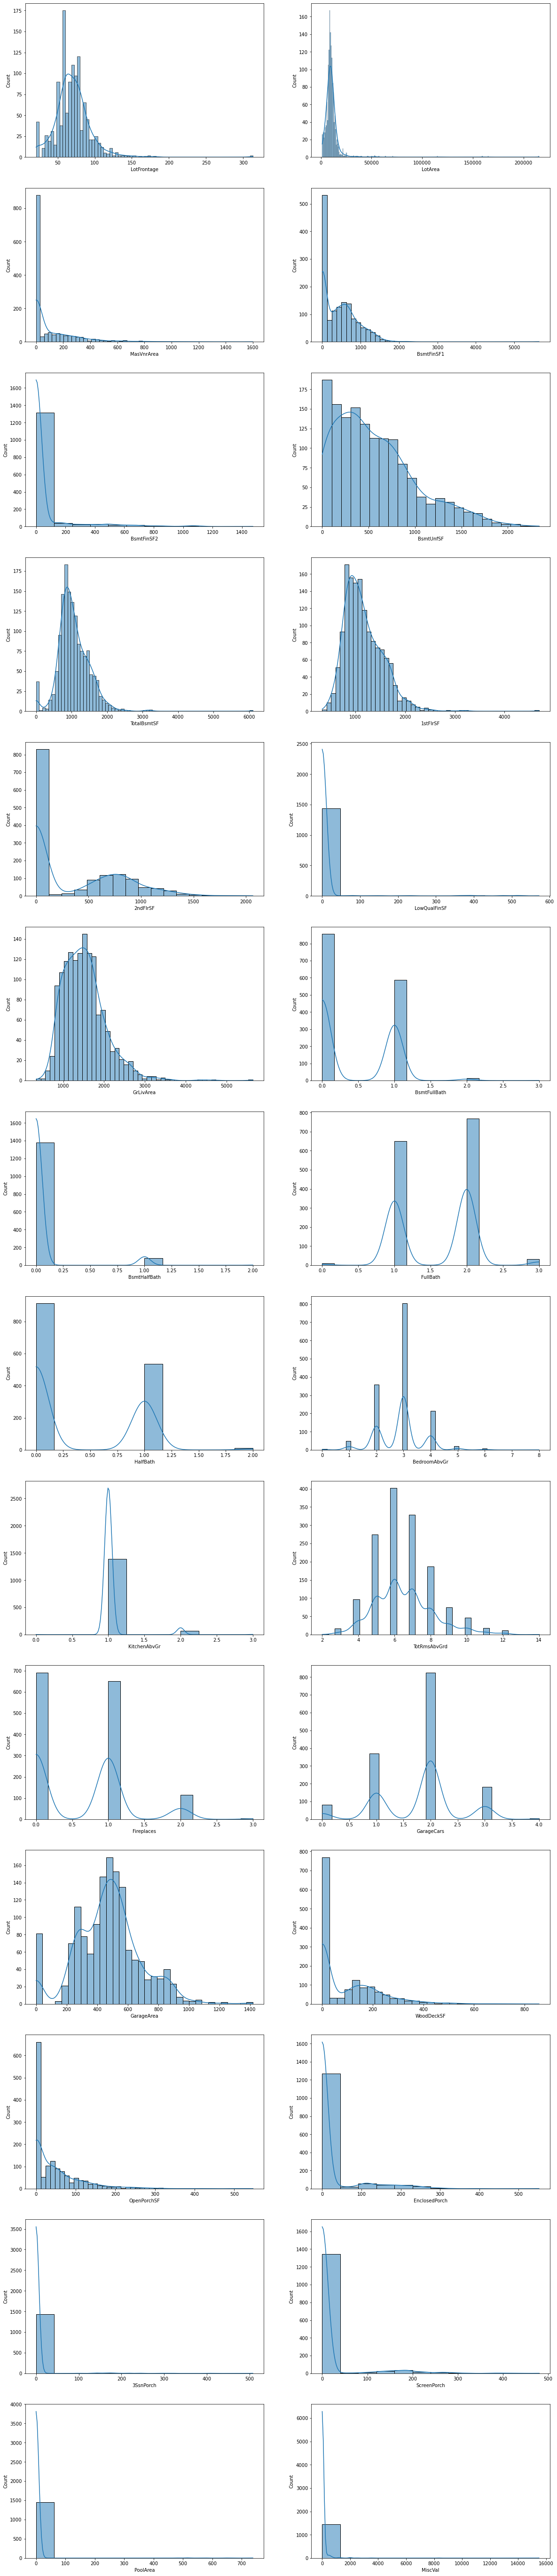

In [28]:
numerical_features=df.select_dtypes('number').columns
nrows=len(numerical_features[0:-1])//ncols

fig, axes=plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,100))
axes=axes.ravel()
for i, col_name in enumerate(numerical_features):
    ax=axes[i]
    sns.histplot(data=df,x=col_name, kde=True,ax=axes[i])

In [ ]:
fig, axes=plt.subplots(nrows=nrows,ncols=ncols,figsize=(18,90))
axes=axes.ravel()

for i, col_name in enumerate(numerical_features[0:-1]):
    ax=axes[i]
    sns.scatterplot(x=col_name,y='SalePrice',data=df,ax=ax)

In [ ]:
sns.pairplot(df[0:-1],corner=True,diag_kind="kde")

In [ ]:
pd.get_dummies

In [ ]:
df.Fence.dtype

In [29]:
X_train,y_train=df[df.columns.difference(['SalePrice','LotFrontage','Electrical','MasVnrArea','MasVnrType'])],np.log(df['SalePrice'])

In [30]:
ordinal_features=list(labels.keys())
ordinal_categories=list(labels.values())

preprocessor=ColumnTransformer(
    transformers=[
            ('numerical',StandardScaler(),make_column_selector(dtype_include='number')),
            ('nominal',OneHotEncoder(drop='first',handle_unknown='infrequent_if_exist',sparse=False),make_column_selector(dtype_include='category')),
            ('ordinal',OrdinalEncoder(categories=ordinal_categories,handle_unknown='error'),ordinal_features)
    ]
)

### Principal Components Regression -PCR

In [31]:
pca=Pipeline(
    steps=[('preprocessor',preprocessor),('PCA',PCA())]
)
pca

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C66D77D790>),
                                                 ('nominal',
                                                  OneHotEncoder(categories='auto',
                                                                dr...
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'Functional',
                                                   'FireplaceQu', 'GarageQual',
                                                   'GarageFinish', 'GarageCond',
                                                   'PavedDrive', 'PoolQC',
                                                   'Fence'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     n_oversamples=10, power_iteration_normalizer='auto',
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

In [33]:
pca_features=pca.fit_transform(X_train)

In [34]:
pca.named_steps['preprocessor'].transformers_

[('numerical',
  StandardScaler(copy=True, with_mean=True, with_std=True),
  ['1stFlrSF',
   '2ndFlrSF',
   '3SsnPorch',
   'BedroomAbvGr',
   'BsmtFinSF1',
   'BsmtFinSF2',
   'BsmtFullBath',
   'BsmtHalfBath',
   'BsmtUnfSF',
   'EnclosedPorch',
   'Fireplaces',
   'FullBath',
   'GarageArea',
   'GarageCars',
   'GrLivArea',
   'HalfBath',
   'KitchenAbvGr',
   'LotArea',
   'LowQualFinSF',
   'MiscVal',
   'OpenPorchSF',
   'PoolArea',
   'ScreenPorch',
   'TotRmsAbvGrd',
   'TotalBsmtSF',
   'WoodDeckSF']),
 ('nominal',
  OneHotEncoder(categories='auto', drop='first', dtype=<class 'numpy.float64'>,
                handle_unknown='infrequent_if_exist', max_categories=None,
                min_frequency=None, sparse=False, sparse_output=False),
  ['Alley',
   'BldgType',
   'BsmtCond',
   'BsmtExposure',
   'BsmtFinType1',
   'BsmtFinType2',
   'BsmtQual',
   'CentralAir',
   'Condition1',
   'Condition2',
   'ExterCond',
   'ExterQual',
   'Exterior1st',
   'Exterior2nd',
   'Fence

In [35]:
preprocessor.named_transformers_['ordinal'].categories_

[array(['Lvl', 'Bnk', 'HLS', 'Low'], dtype=object),
 array(['ELO', 'NoSeWa', 'NoSeWr', 'AllPub'], dtype=object),
 array(['Gtl', 'Mod', 'Sev'], dtype=object),
 array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object),
 array(['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin', '2.5Unf',
        'SFoyer', 'SLvl'], dtype=object),
 array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype=object),
 array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype=object),
 array(['Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype=object),
 array(['Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype=object),
 array(['No Basement', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype=object),
 array(['No Basement', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype=object),
 array(['No Basement', 'No', 'Mn', 'Av', 'Gd'], dtype=object),
 array(['No Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
       dtype=object),
 array(['No Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
       dtype=object),
 array(['Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype=

In [36]:
pca.named_steps['PCA'].n_components_,pca.named_steps['PCA'].n_features_

(580, 580)

In [37]:
pca_variance=pca.named_steps['PCA'].explained_variance_ratio_[:30]

Text(0, 0.5, 'Variance ratio')

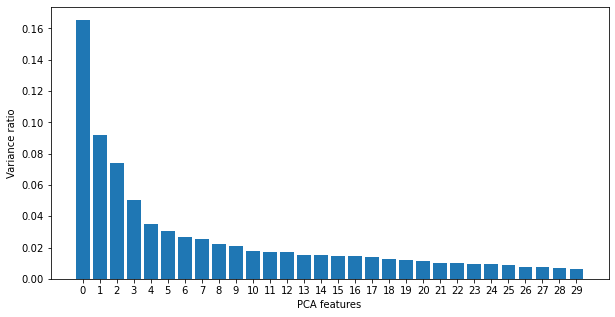

In [38]:
plt.figure(figsize=(10,5))
plt.bar(range(30),pca_variance)
plt.xlabel('PCA features')
plt.xticks(range(30))
plt.ylabel('Variance ratio')

In [39]:
reg=LinearRegression().fit(pca_features[:,:30],y_train)

In [42]:
metrics=[r2_score,mean_squared_error,mean_absolute_error,max_error,
         median_absolute_error,mean_absolute_percentage_error,]

def get_performance(real_value,estimated_value,metrics=metrics):
    perfs=[]
    for metric_func in metrics:
        perfs.append((metric_func.__name__,metric_func(real_value,estimated_value)))
    """
    Plot the predictions and real value: make a comparison
    """
    fig,ax=plt.subplots(ncols=2,figsize=(8,4))
    PredictionErrorDisplay.from_predictions(real_value,estimated_value,
                                            kind='actual_vs_predicted',ax=ax[0])
    ax[0].set_title('Valeurs réelles vs. predictions')
    PredictionErrorDisplay.from_predictions(real_value,estimated_value,
                                            kind='residual_vs_predicted',ax=ax[1])
    ax[1].set_title('Valeurs résiduelles vs. predictions')
    fig.suptitle('Train set')
    return pd.DataFrame(perfs,columns=['metric','value'])  

metric     value
0                        r2_score  0.870670
1              mean_squared_error  0.020622
2             mean_absolute_error  0.098032
3                       max_error  1.867339
4           median_absolute_error  0.075061
5  mean_absolute_percentage_error  0.008200

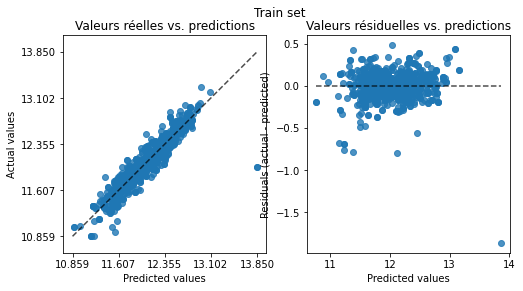

In [41]:
y_train_pred=reg.predict(pca_features[:,:30])
get_performance(y_train,y_train_pred,metrics)

In [42]:
#cross_validate(X_train,y_train,)

### Partial Least Square -PLS

In [43]:
pls=Pipeline(
    steps=[('preprocessor',preprocessor),('PLS',PLSRegression(n_components=4))]
)
pls

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001ABF9B6EDC0>),
                                                 ('nominal',
                                                  OneHotEncoder(categories='auto',
                                                                dr...
                                                   'ExterCond', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'Functional',
                                                   'FireplaceQu', 'GarageQual',
                                                   'GarageFinish', 'GarageCond',
                                                   'PavedDrive', 'PoolQC',
                                                   'Fence'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('PLS',
                 PLSRegression(copy=True, max_iter=500, n_components=4,
                               scale=True, tol=1e-06))],
         verbose=False)

In [44]:
pls_features=pls.fit_transform(X_train,y_train)

In [45]:
pls_features

(array([[ 3.93244536e+00, -2.85099672e+00, -9.41319515e-01,
          2.56454042e-03],
        [ 5.82187815e-01,  9.36576942e-01,  4.48628105e-01,
         -2.65014720e+00],
        [ 5.38258886e+00, -1.70194963e+00,  2.04169772e-01,
          1.30140133e+00],
        ...,
        [ 2.50764319e+00,  4.51315647e+00, -1.58593947e+00,
          2.30069567e+00],
        [-2.44152858e+00,  8.85138744e-01, -7.92724945e-01,
         -2.13374282e+00],
        [-1.58261534e+00,  3.28419688e-02,  1.15895509e+00,
         -2.21510155e+00]]),
 array([[ 1.7718416 ,  1.12288474, -0.77449198, -0.38176899],
        [ 0.67310596,  0.42657335, -0.29422222, -0.14503045],
        [ 2.32224474,  1.47169656, -1.01507941, -0.50036134],
        ...,
        [ 3.7163312 ,  2.35518322, -1.62445035, -0.8007375 ],
        [-1.26436023, -0.80127412,  0.55266614,  0.27242476],
        [-0.97026292, -0.61489324,  0.42411288,  0.20905723]]))

In [46]:
pls.score(X_train,y_train)

0.9205543868724151

In [47]:
pls.named_steps['PLS'].y_weights_

array([[ 0.19277782,  0.12217078, -0.08426536, -0.04153678]])

metric     value
0                        r2_score  0.920554
1              mean_squared_error  0.012668
2             mean_absolute_error  0.077302
3                       max_error  1.148289
4           median_absolute_error  0.056162
5  mean_absolute_percentage_error  0.006461

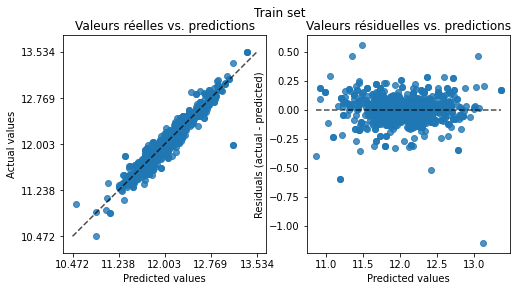

In [48]:
y_train_pred=pls.predict(X_train).squeeze()
get_performance(y_train,y_train_pred,metrics)

In [49]:
cv_results=cross_validate(pls,X_train,y_train,cv=5,
                          scoring=('r2','neg_mean_squared_error'),
                          error_score='raise',return_train_score=True)
pd.DataFrame(cv_results)

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.167985    0.063993  0.883130  0.922768                    -0.017463   
1  0.176601    0.062495  0.865234  0.926219                    -0.024356   
2  0.167295    0.055581  0.860081  0.925773                    -0.023478   
3  0.181057    0.071994  0.875491  0.923270                    -0.018018   
4  0.185584    0.055962  0.810322  0.936041                    -0.029014   

   train_neg_mean_squared_error  
0                     -0.012506  
1                     -0.011372  
2                     -0.011677  
3                     -0.012487  
4                     -0.010301

#### Hyperparamaters tuning 

In [52]:
param_grid={'PLS__n_components':np.arange(start=1,stop=50,step=1)}
grid_search=GridSearchCV(pls,param_grid,cv=10,scoring=('r2','neg_mean_squared_error'),refit='neg_mean_squared_error',return_train_score=True)
grid_search

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001ABF9B6EDC0>),...
                                                      scale=True, tol=1e-06))],
                                verbose=False),
             n_jobs=None,
             param_grid={'PLS__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [53]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001ABF9B6EDC0>),...
                                                      scale=True, tol=1e-06))],
                                verbose=False),
             n_jobs=None,
             param_grid={'PLS__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [54]:
best_params=grid_search.best_params_
print(f"Best params : {best_params}")

Best params : {'PLS__n_components': 3}


In [55]:
grid_cv_results=grid_search.cv_results_
for score in ['r2','neg_mean_squared_error']:
    print (f"Best Scores: {score}")
    for group in ['train','test']:
        mean_score=grid_cv_results[f"mean_{group}_{score}"][best_params['PLS__n_components']]
        std_score=grid_cv_results[f"std_{group}_{score}"][best_params['PLS__n_components']]
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

Best Scores: r2
train===================
 Mean score (std) 0.9234941290083587 (0.004098375348134444)

test===================
 Mean score (std) 0.8559728161732952 (0.06290192066553235)

Best Scores: neg_mean_squared_error
train===================
 Mean score (std) -0.012196497136825924 (0.0006521293790583958)

test===================
 Mean score (std) -0.022562185672022783 (0.009184313437632633)



### Robust Regression

#### Outliers

### Gradient Boosting

In [105]:
GBoost=Pipeline(
    steps=[('preprocessor',preprocessor),('GBOOST',GradientBoostingRegressor(n_estimators=260))]
     )
GBoost

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C66D77D790>),
                                                 ('nominal',
                                                  OneHotEncoder(categories='auto',
                                                                dr...
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1,
                                           loss='squared_error', max_depth=3,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=260,
                                           n_iter_no_change=None,
                                           random_state=None, subsample=1.0,
                                           tol=0.0001, validation_fraction=0.1,
                                           verbose=0, warm_start=False))],
         verbose=False)

In [166]:
GBoost.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C66D77D790>),
                                                 ('nominal',
                                                  OneHotEncoder(categories='auto',
                                                                dr...
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1,
                                           loss='squared_error', max_depth=3,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=260,
                                           n_iter_no_change=None,
                                           random_state=None, subsample=1.0,
                                           tol=0.0001, validation_fraction=0.1,
                                           verbose=0, warm_start=False))],
         verbose=False)

In [158]:
y_train_pred=GBoost.predict(X_train)

metric     value
0                        r2_score  0.976127
1              mean_squared_error  0.003807
2             mean_absolute_error  0.047813
3                       max_error  0.370189
4           median_absolute_error  0.039465
5  mean_absolute_percentage_error  0.003991

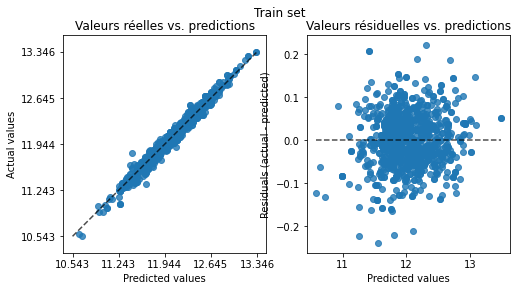

In [159]:
get_performance(y_train,y_train_pred,metrics)

In [160]:
cv_results=cross_validate(GBoost,X_train,y_train,scoring=('r2','neg_mean_squared_error'),
                         error_score='raise',return_train_score=True)
pd.DataFrame(cv_results)

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  4.755550    0.031229  0.910054  0.979753                    -0.013440   
1  4.999619    0.031271  0.896772  0.978849                    -0.018656   
2  4.505417    0.032000  0.889040  0.980197                    -0.018619   
3  7.310672    0.031250  0.906438  0.978024                    -0.013539   
4  6.343161    0.124991  0.901849  0.978829                    -0.015013   

   train_neg_mean_squared_error  
0                     -0.003278  
1                     -0.003260  
2                     -0.003115  
3                     -0.003576  
4                     -0.003410

#### Features importance

Importance
OverallQual     0.401243
GrLivArea       0.154649
KitchenQual     0.050746
TotalBsmtSF     0.049923
GarageCars      0.042953
ExterQual       0.031980
BsmtQual        0.030498
GarageFinish    0.028017

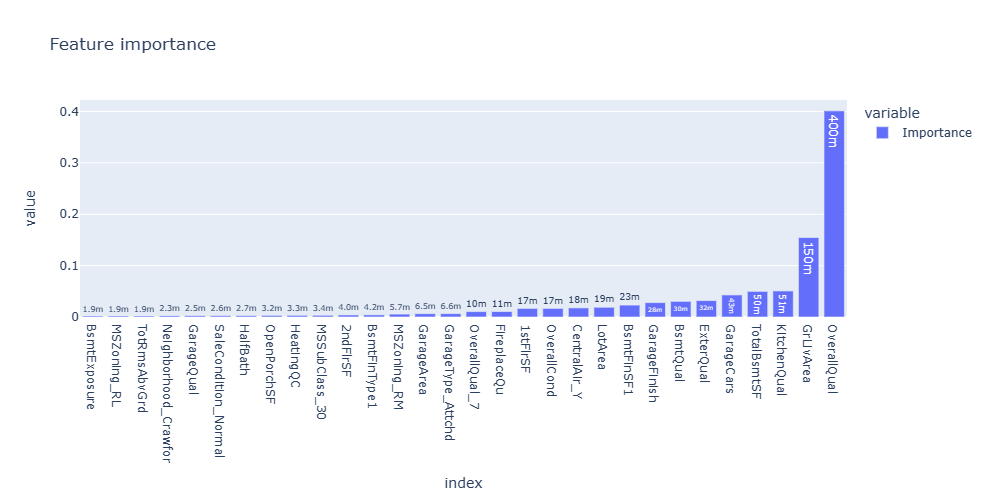

In [140]:
def feature_importance():
    feature_importance=pd.DataFrame(GBoost['GBOOST'].feature_importances_,index=model_features,columns=['Importance'])
    """
    Plot feature importances
    """
    display(feature_importance.nlargest(8,'Importance'))
    pd.options.plotting.backend = "plotly"
    return (feature_importance
        .sort_values('Importance',ascending=True)
        .tail(30)
        .plot.bar(title='Feature importance',text_auto='.2s',height=500)
        )
feature_importance()

In [180]:
explainer=shap.TreeExplainer(GBoost['GBOOST'],feature_names=model_features)
shap_values=explainer.shap_values(preprocessor.transform(X_train),y_train)
expected_value=explainer.expected_value

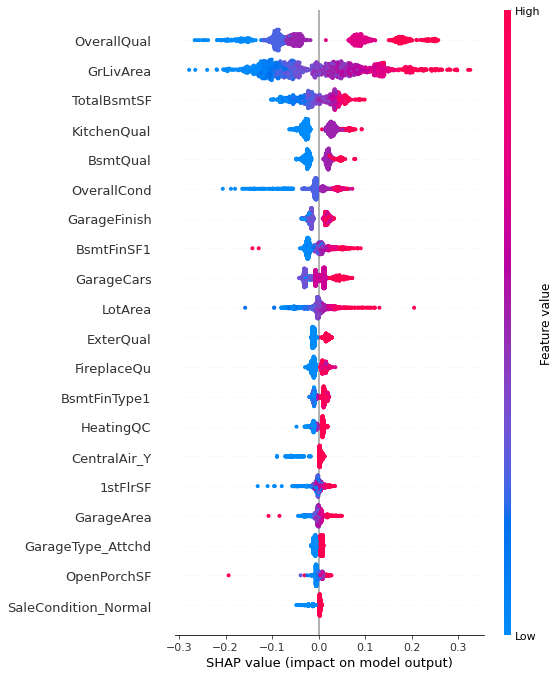

In [181]:
shap.summary_plot(shap_values,preprocessor.transform(X_train),feature_names=model_features)

### LightGBM

In [93]:
lightGBM=Pipeline(
    steps=[('preprocessor',preprocessor),('LGBM',LGBMRegressor(num_leaves=22))]
)

In [94]:
lightGBM.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C66D77D790>),
                                                 ('nominal',
                                                  OneHotEncoder(categories='auto',
                                                                dr...
                 LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=1.0, importance_type='split',
                               learning_rate=0.1, max_depth=-1,
                               min_child_samples=20, min_child_weight=0.001,
                               min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                               num_leaves=22, objective=None, random_state=None,
                               reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                               subsample=1.0, subsample_for_bin=200000,
                               subsample_freq=0))],
         verbose=False)

In [95]:
y_train_pred=lightGBM.predict(X_train)

metric     value
0                        r2_score  0.979603
1              mean_squared_error  0.003252
2             mean_absolute_error  0.040194
3                       max_error  0.459405
4           median_absolute_error  0.030254
5  mean_absolute_percentage_error  0.003362

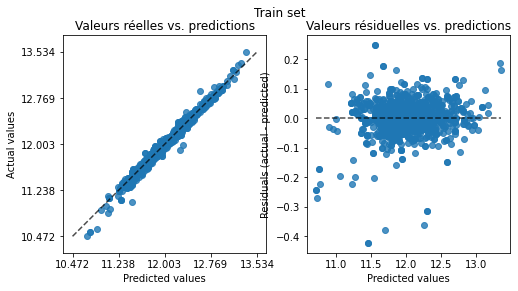

In [96]:
get_performance(y_train,y_train_pred,metrics)

In [75]:
cv_results=cross_validate(lightGBM,X_train,y_train,scoring=('r2','neg_mean_squared_error'),
                     error_score='raise',return_train_score=True,cv=5)
pd.DataFrame(cv_results)

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.294501    0.031252  0.905220  0.980714                    -0.014162   
1  0.201959    0.031230  0.887178  0.984139                    -0.020390   
2  0.218734    0.031252  0.883952  0.981587                    -0.019473   
3  0.220156    0.031249  0.899672  0.981966                    -0.014518   
4  0.234337    0.046894  0.892705  0.983021                    -0.016412   

   train_neg_mean_squared_error  
0                     -0.003123  
1                     -0.002445  
2                     -0.002897  
3                     -0.002935  
4                     -0.002735

In [76]:
for score in ['r2','neg_mean_squared_error']:
    print(f"=={score}")
    for group in ['train','test']: 
        mean_score=cv_results[f"{group}_{score}"].mean()
        std_score=cv_results[f"{group}_{score}"].std()
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

==r2
train===================
 Mean score (std) 0.9822853467063473 (0.001186312070725835)

test===================
 Mean score (std) 0.8937454531714998 (0.007834675715144204)

==neg_mean_squared_error
train===================
 Mean score (std) -0.0028267085861622522 (0.00022750103206412847)

test===================
 Mean score (std) -0.016991147607899555 (0.0025363634436398786)



#### Hyperparameters tuning

In [49]:
param_grid={'LGBM__num_leaves':np.arange(20,40,1)}
grid_search=GridSearchCV(lightGBM,param_grid,scoring=('r2','neg_mean_squared_error'),
                            cv=10,refit='neg_mean_squared_error',return_train_score=True)
grid_search

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001C66D77D790>),...
                                                      reg_alpha=0.0,
                                                      reg_lambda=0.0,
                                                      silent='warn',
                                                      subsample=1.0,
                                                      subsample_for_bin=200000,
                                                      subsample_freq=0))],
                                verbose=False),
             n_jobs=None,
             param_grid={'LGBM__num_leaves': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39])},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [50]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001C66D77D790>),...
                                                      reg_alpha=0.0,
                                                      reg_lambda=0.0,
                                                      silent='warn',
                                                      subsample=1.0,
                                                      subsample_for_bin=200000,
                                                      subsample_freq=0))],
                                verbose=False),
             n_jobs=None,
             param_grid={'LGBM__num_leaves': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39])},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [69]:
grid_search.best_params_

{'LGBM__num_leaves': 22}

In [ ]:
plot.metric()

#### Features importance

<AxesSubplot:>

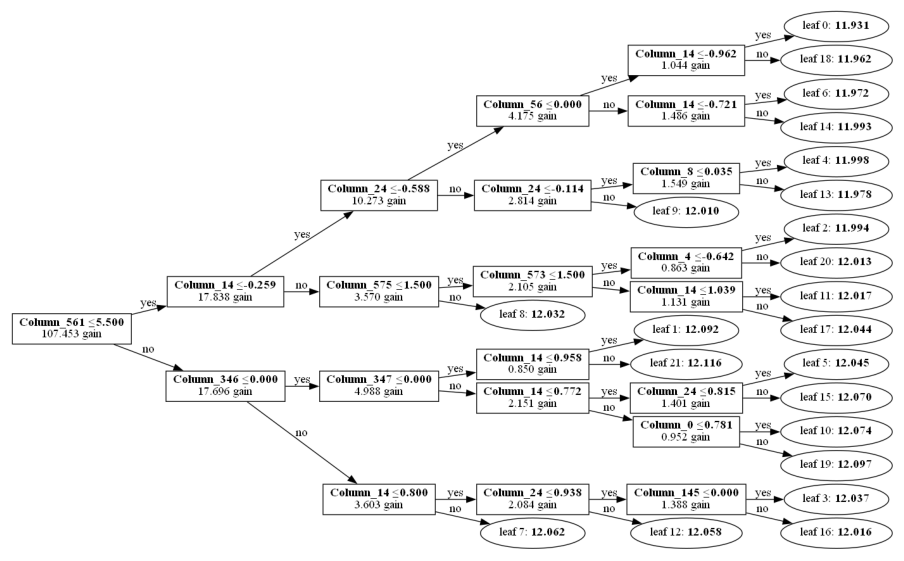

In [175]:
plot_tree(lightGBM['LGBM'],figsize=(14,8),dpi=90,show_info=['split_gain'])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

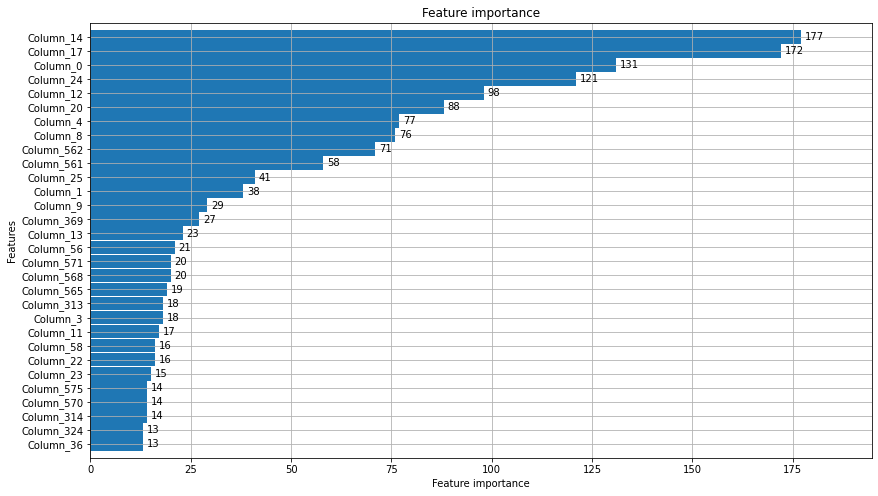

In [103]:
plot_importance(lightGBM['LGBM'],max_num_features=30,height=0.98,figsize=(14,8),importance_type='split')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

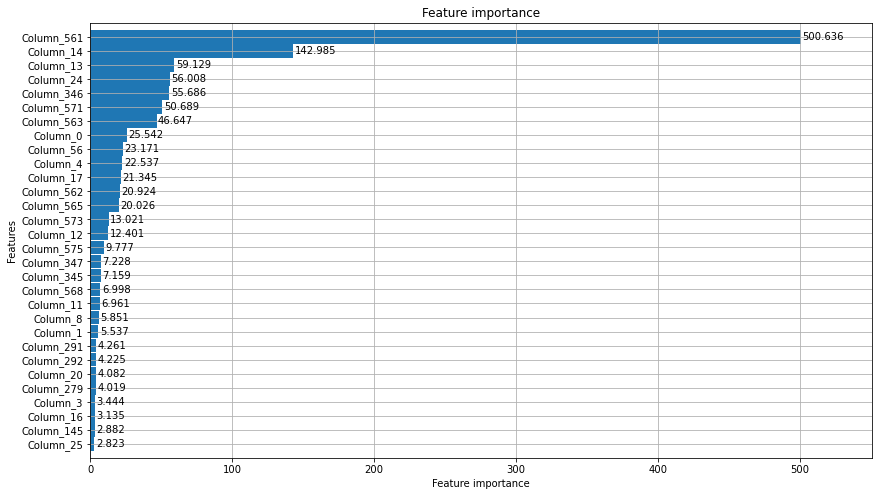

In [102]:
plot_importance(lightGBM['LGBM'],max_num_features=30,height=0.98,figsize=(14,8),importance_type='gain')

In [79]:
explainer=shap.TreeExplainer(lightGBM['LGBM'],feature_names=model_features)
shap_values=explainer.shap_values(preprocessor.transform(X_train),y_train)
expected_value=explainer.expected_value

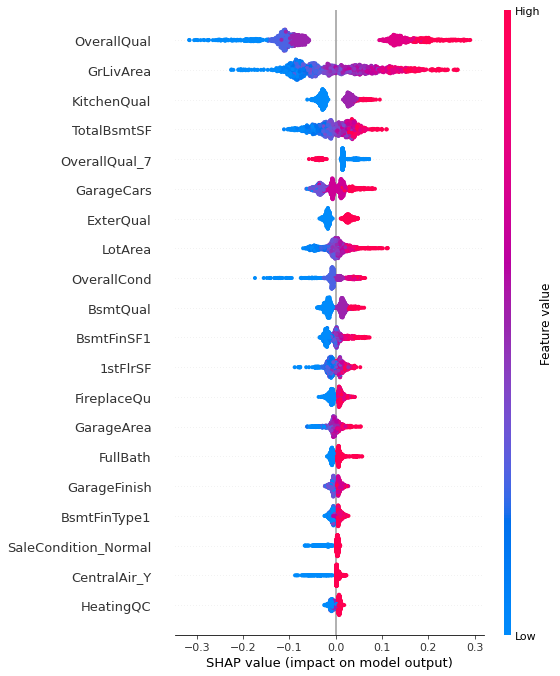

In [80]:
shap.summary_plot(shap_values,preprocessor.transform(X_train),feature_names=model_features)

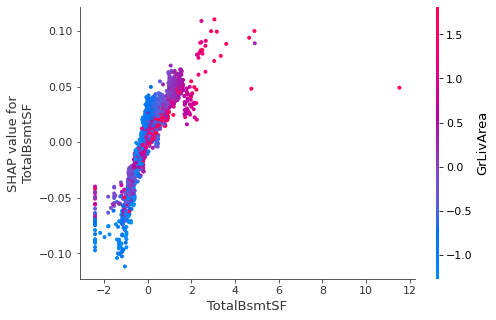

In [82]:
shap.dependence_plot('TotalBsmtSF',shap_values,preprocessor.transform(X_train),feature_names=model_features)

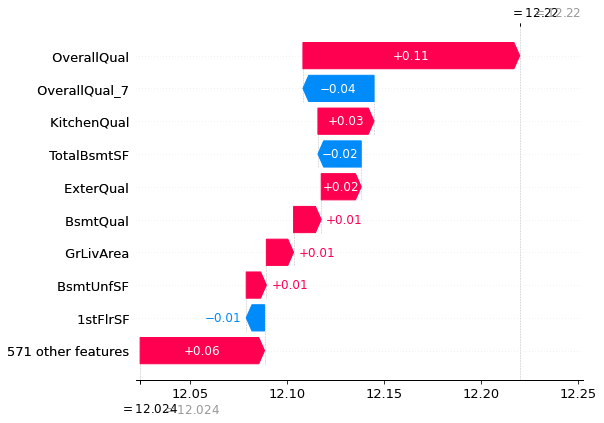

In [83]:
shap.plots._waterfall.waterfall_legacy(expected_value,shap_values[0,:],preprocessor.transform(X_train)[0,:],feature_names=model_features)

In [85]:
shap.force_plot(expected_value,shap_values[0,:],preprocessor.transform(X_train)[0,:],feature_names=model_features)

### CatBoost

In [36]:
catBoost=Pipeline(
                steps=[('preprocessor',preprocessor),('CATBOOST',CatBoostRegressor(iterations=356,verbose=0))]
)
catBoost

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C66D77D790>),
                                                 ('nominal',
                                                  OneHotEncoder(categories='auto',
                                                                dr...
                                                   'OverallCond', 'ExterQual',
                                                   'ExterCond', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'Functional',
                                                   'FireplaceQu', 'GarageQual',
                                                   'GarageFinish', 'GarageCond',
                                                   'PavedDrive', 'PoolQC',
                                                   'Fence'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('CATBOOST',
                 <catboost.core.CatBoostRegressor object at 0x000001C66D2A0D30>)],
         verbose=False)

In [37]:
catBoost.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C66D77D790>),
                                                 ('nominal',
                                                  OneHotEncoder(categories='auto',
                                                                dr...
                                                   'OverallCond', 'ExterQual',
                                                   'ExterCond', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'Functional',
                                                   'FireplaceQu', 'GarageQual',
                                                   'GarageFinish', 'GarageCond',
                                                   'PavedDrive', 'PoolQC',
                                                   'Fence'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('CATBOOST',
                 <catboost.core.CatBoostRegressor object at 0x000001C66D2A0D30>)],
         verbose=False)

In [38]:
catBoost['CATBOOST'].get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 356,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.10065100342035294,
 'score_function': 'C

In [39]:
y_train_pred=catBoost.predict(X_train)

In [40]:
get_performance(y_train,y_train_pred)

NameError: name 'get_performance' is not defined

In [693]:
cv_results=cross_validate(catBoost,X_train,y_train,scoring=('r2','neg_mean_squared_error'),
                          cv=5,error_score='raise',return_train_score=True)
pd.DataFrame(cv_results)

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  43.748646    0.105303  0.902220  0.998289                    -0.014610   
1  48.696813    0.078095  0.885792  0.997690                    -0.020641   
2  37.425441    0.296854  0.886914  0.998139                    -0.018976   
3  35.286664    0.078095  0.900797  0.997418                    -0.014356   
4  35.864633    0.164490  0.890913  0.998144                    -0.016686   

   train_neg_mean_squared_error  
0                     -0.000277  
1                     -0.000356  
2                     -0.000293  
3                     -0.000420  
4                     -0.000299

In [694]:
for score in ['r2','neg_mean_squared_error']:
    print(f"=={score}")
    for group in ['train','test']: 
        mean_score=cv_results[f"{group}_{score}"].mean()
        std_score=cv_results[f"{group}_{score}"].std()
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

==r2
train===================
 Mean score (std) 0.9979360586089777 (0.0003282384940588908)

test===================
 Mean score (std) 0.8933272686817872 (0.00690832851678043)

==neg_mean_squared_error
train===================
 Mean score (std) -0.00032898325412810943 (5.289005134474697e-05)

test===================
 Mean score (std) -0.017053755212263814 (0.002447299636847798)



#### Hyperparameters tuning

In [76]:
param_grid={'CATBOOST__iterations':np.arange(350,375,1)}
grid_search=GridSearchCV(catBoost,param_grid,scoring=('r2','neg_mean_squared_error'),
                            cv=10,refit='neg_mean_squared_error',return_train_score=True)
grid_search

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001ABF9B6EDC0>),...
                                        <catboost.core.CatBoostRegressor object at 0x000001ABF9F76AF0>)],
                                verbose=False),
             n_jobs=None,
             param_grid={'CATBOOST__iterations': array([350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374])},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [298]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001ABF9B6EDC0>),...
                                        <catboost.core.CatBoostRegressor object at 0x000001ABF9F76AF0>)],
                                verbose=False),
             n_jobs=None,
             param_grid={'CATBOOST__iterations': array([350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374])},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [296]:
best_params=grid_search.best_params_
print(f"Best params : {best_params}")

Best params : {'CATBOOST__iterations': 356}


In [297]:
grid_cv_results=grid_search.cv_results_
best_param_index=np.where(grid_cv_results['rank_test_neg_mean_squared_error']==1)[0][0]
for score in ['r2','neg_mean_squared_error']:
    print (f"Best Scores: {score}")
    for group in ['train','test']:
        mean_score=grid_cv_results[f"mean_{group}_{score}"][best_param_index]
        std_score=grid_cv_results[f"std_{group}_{score}"][best_param_index]
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

Best Scores: r2
train===================
 Mean score (std) 0.9836409699397028 (0.0013019142875623105)

test===================
 Mean score (std) 0.905212754627974 (0.0198452282810796)

Best Scores: neg_mean_squared_error
train===================
 Mean score (std) -0.002610642418775858 (0.00023554354323216938)

test===================
 Mean score (std) -0.015083308680588048 (0.004152363649280992)



#### Features importances

In [56]:
def get_input_features(model_pipeline):
    
    """ Get model feature names used in training
    """
    all_feature_names = []

    for step_name, pipe_trans, feat_names in model_pipeline["preprocessor"].transformers_:
        if step_name == "nominal":
            all_feature_names.extend(pipe_trans
                                     .get_feature_names_out()
                                    )
        else:
            all_feature_names.extend(feat_names)
    return all_feature_names

In [57]:
model_features=get_input_features(catBoost)

Importances
Feature Id              
OverallQual    16.426659
GrLivArea      13.951493
TotalBsmtSF     7.945105
2ndFlrSF        3.928714
GarageArea      3.514305
GarageCars      2.998665
BsmtQual        2.851361
OverallCond     2.777149

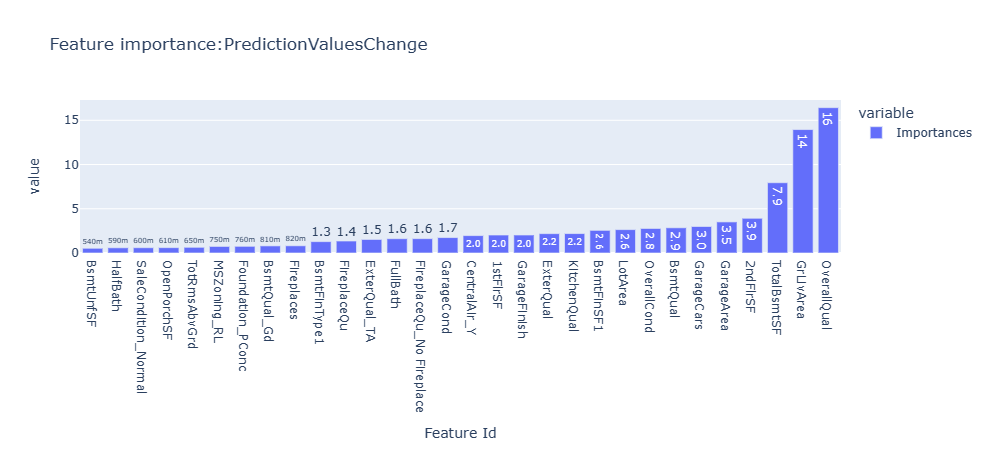

In [751]:
train_pool=Pool(data=preprocessor.transform(X_train),label=y_train,feature_names=model_features)

def feature_importance(pool_data=train_pool,type='PredictionValuesChange',top=30):
    feature_importance=catBoost.named_steps['CATBOOST'].get_feature_importance(pool_data,
                                                                               type,prettified=True)
    
    if type in ['PredictionValuesChange','LossFunctionChange']:
        feature_importance.set_index('Feature Id',inplace=True)
        value='Importances'
    else :
        feature_importance=feature_importance.astype({'First Feature Index':'object','Second Feature Index':'object'})
        feature_importance['Features Id'] = " ".join([feature_importance['First Feature Index'], feature_importance['Second Feature Index']])
        feature_importance.drop(['First Feature Index','Second Feature Index'],axis=1,inplace=True)
        feature_importance.set_index('Features Id',inplace=True)
        value='Interaction'
        
        
    display(feature_importance.head(8))
    """
    Plot features importances
    """
    pd.options.plotting.backend = "plotly"
    return (feature_importance
     .sort_values(value,key=lambda v:abs(v),ascending=True)
     .tail(30)
     .plot.bar(title=f'Feature importance:{type}',text_auto='.2s',height=450)
    )


feature_importance()

Importances
Feature Id               
OverallQual      0.054128
GrLivArea        0.054072
TotalBsmtSF      0.021194
1stFlrSF         0.019052
LotArea          0.017358
ExterQual        0.014400
BsmtFinType1     0.013876
OverallCond      0.013869

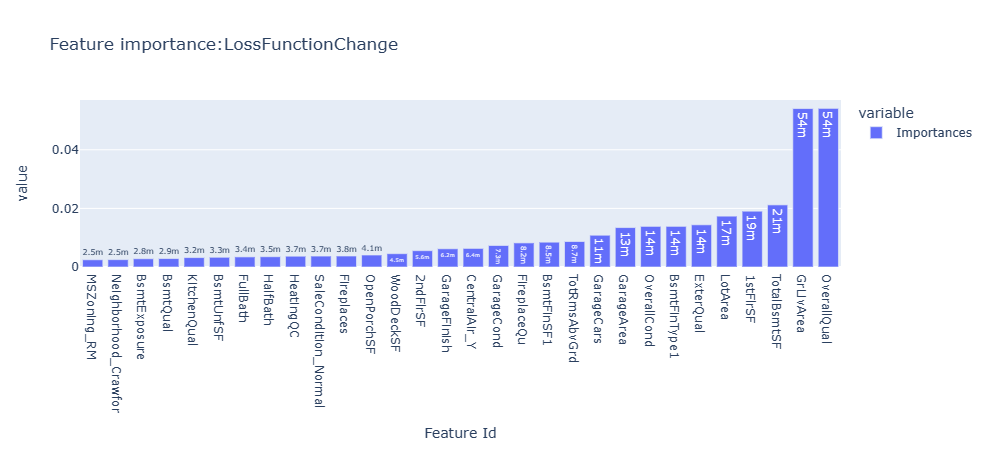

In [734]:
feature_importance(pool_data=train_pool,type='LossFunctionChange')

In [611]:
feature_importance(pool_data=train_pool,type='Interaction')

TypeError: sequence item 0: expected str instance, Series found

In [742]:
shap_values=catBoost.named_steps['CATBOOST'].get_feature_importance(train_pool,'ShapValues')

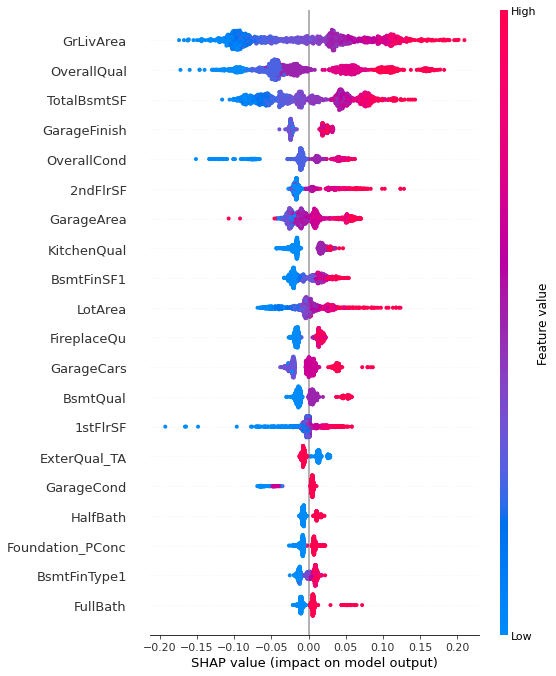

In [744]:
shap.summary_plot(shap_values[:,:-1],preprocessor.transform(X_train),feature_names=model_features)

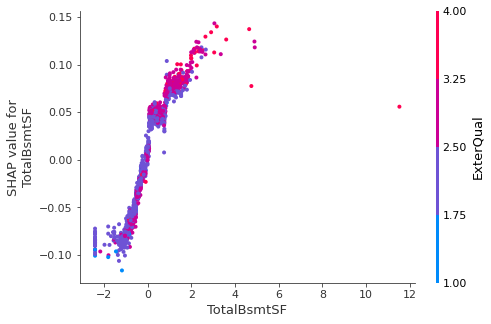

In [748]:
shap.dependence_plot('TotalBsmtSF',shap_values[:,:-1],preprocessor.transform(X_train),feature_names=model_features)

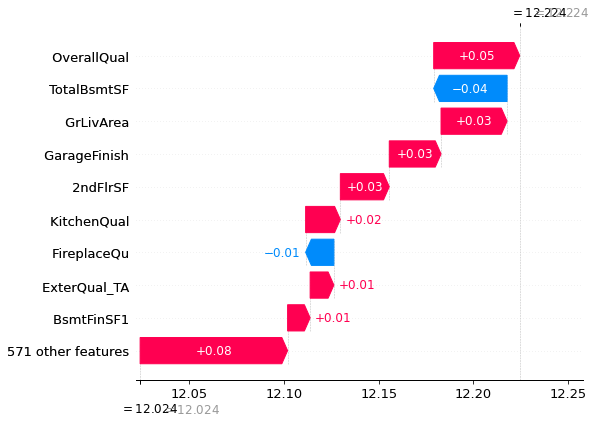

In [749]:
shap.plots._waterfall.waterfall_legacy(shap_values[0,-1],shap_values[0,:-1],preprocessor.transform(X_train)[0,:],feature_names=model_features)

In [750]:
shap.initjs()
shap.force_plot(shap_values[0,-1],shap_values[0,:-1],preprocessor.transform(X_train)[0,:],feature_names=model_features)